In [8]:
import math
import cmath
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
lr = linear_model.LinearRegression()

# import plotly as py
# py.tools.set_credentials_file(username='VeeraMarni', api_key='')

# def plot(y, Y):
#     fig, ax = plt.subplots(2,1)
#     ax[0].plot(t,y)
#     ax[1].plot(frq,Y)
#     ax[0].set_xlabel('Time')
#     ax[0].set_ylabel('Amplitude')
#     ax[1].set_xlabel('Freq (Hz)')
#     ax[1].set_ylabel('|Y(freq)|')
#     plot_url = py.plotly.plot_mpl(fig, filename='mpl-basic-fft')

class Plot:
    
    def __init__(self):
        fig = plt.figure()
    
    def plot1(self, x, y, title="Signal"):
        plt.title(title)
        plt.plot(x, y,)
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.show()


    def plot2(self, x, y, X, Y, title1="Signal", title2="Spectrum"):
        plt.subplot(211)
        plt.title(title1)
        plt.plot(x, y,)
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.subplot(212)
        plt.title(title2)
        plt.plot(X, Y)
        plt.xlabel('Freq (Hz)')
        plt.ylabel('|Y(freq)|')
        plt.tight_layout()
        plt.show()
    
    def plot3(self, x, y, X, Y, title1="Signal", title2="Reecovred Signal"):
        plt.subplot(211)
        plt.title(title1)
        plt.plot(x, y,)
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.subplot(212)
        plt.title(title2)
        plt.plot(X, Y)
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()
    
# Making a signal

def makeSignal(amp=1, f=1,sr=150, phi=0):
    '''
    f: frequency of the signal
    sr: sampling rate
    '''    
    si = 1.0/(sr) # sampling interval
    t = np.arange(0,1,si)  # time vector generation
    y = amp * np.sin(2*np.pi*f*t + math.radians(phi))
    return y,t

# Fourier Transformation

def fft(y, sr, upperHalf=False):
    '''
    y: signal
    sr: sampling rate
    '''
    n = len(y) # length of y
    k = np.arange(n)
    T = n/sr
    frq = k/T # 2 side frequency range
    Y = np.fft.fft(y)

    if upperHalf == True:
        return Y, frq
    else:
        Y = Y[range(int(n/2))]
        frq = frq[range(int(n/2))] # 1 side frequency range
        return Y, frq


# Fourier Transformation Power

def fftPow(y, sr, upperHalf=False):
    '''
    y: signal
    sr: sampling rate
    '''
    Y, frq = fft(y, sr, upperHalf)
    Y = np.abs(Y)/np.sum(np.abs(Y)) # removing freq when n=0
    return Y[1:], frq[1:]
    
# Add Noise into the signal

def addNoise(y, mu=0.1, sd=0.1):
    n = len(y)
    return y + np.random.normal(loc=mu, scale=sd, size=n)

# identifying the frequency with highest power and making it zero

def maxFreqPow(Y, frq):
    index = np.argmax(Y)
    Y[index] = 0 # removing the power for selected freq
    return frq[index]

def estimateSignal(y, sr, n=1, phase=False, plt=False):
    
    # Fourier transform
    Y, frq = fft(y=y, sr=sr)
    # Power at each frequency
    Ypow = np.abs(Y)/np.sum(np.abs(Y))
    
    # frequency estimation
    frqR = list()
    # n is choosen because there are n frequencies with significant power in the signal
    for i in range(n): 
        index = np.argmax(Ypow)
        Ypow[index] = 0 # removing the frequency with highest powre
        maxFreq = frq[index]
        frqR.append(maxFreq)
    
    # reset Ypow
    Ypow = np.abs(Y)/np.sum(np.abs(Y))
        
    # respective phase estimation 
    phiR = list()
    if phase == True:
        for i in range(n):
            phiR.append(-math.degrees(cmath.phase(Y[frqR[i]])))
    else:
        phiR = [0 for i in range(n)]
        
    # generate data for linear regression to estimate amplitudes of each frequency
    yhat = makeSignal(f=frqR[0], sr=sr, phi=math.radians(phiR[0]))[0]
    X = yhat    
    for i in range(1,n):
        yhat = makeSignal(f=frqR[i], sr=sr, phi=math.radians(phiR[i]))[0]
        X = np.vstack((X,yhat))
    X = X.T
    
    # linear regression
#     lr.fit(X,y)
#     w = lr.coef_
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)
    
    if plt == True:
        draw.plot2(t, y, frq[1:], Ypow[1:])
    
    if phase == False:
        return w, frqR
    else:
        return w, frqR, phiR
    

draw = Plot()

In [ ]:
# signal generation with 2 different frequencies and 2 different amplitudes
sr = 600
y1, t = makeSignal(amp=2, f=20, sr=sr); y2, t = makeSignal(amp=4, f=40, sr=sr)
y = y1 + y2
Y, frq = fftPow(y=y, sr=sr)
draw.plot2(t,y,frq,Y)
y1, t = makeSignal(amp=8, f=20, sr=sr); y2, t = makeSignal(amp=4, f=80, sr=sr)
y = y1 + y2
Y, frq = fftPow(y=y, sr=sr)
draw.plot2(t,y,frq,Y)
print "Note: The signal with high amplitude has high power in both the cases"

In [ ]:
# esitmating the frequencies, Amplitudes and isolate noise
sr = 600
y1, t = makeSignal(amp=8, f=2, sr=sr); y2, t = makeSignal(amp=4, f=40, sr=sr)
y = addNoise(y=y1 + y2, mu=0.1, sd=1) # noisy signal
wR, frqR = estimateSignal(y=y,sr=sr,n=2, plt=True)
# Recovering signal using esitmates
y1, t = makeSignal(amp=wR[0], f=frqR[0], sr=sr); y2, t = makeSignal(amp=wR[1], f=frqR[1], sr=sr)
yhat = y1 + y2 
draw.plot3(t, y, t, yhat, title1="original signal with noise", title2="Recovered Signal")
print "Amplitudes Recovered: ", wR, "Frequencies Recovered",frqR

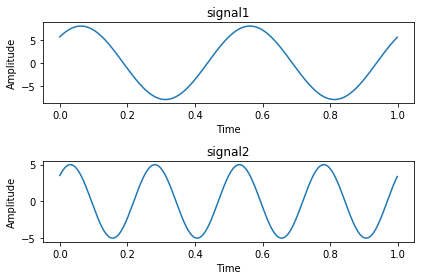

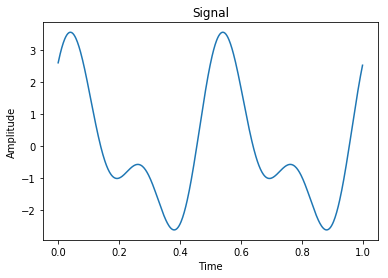

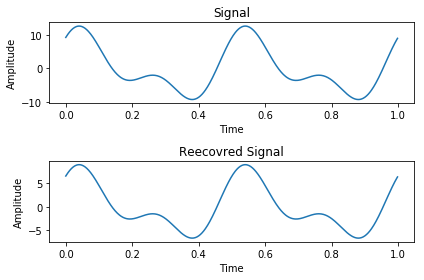

Amplitudes Original :  [8, 5]  Frequencies Original : [2, 4]  Phase Original : [45, 45]
Amplitudes Recovered:  [ 5.73386329  3.58366456]  Frequencies Recovered: [2, 4]  Phase Recovered: [45.00000000000002, 44.99999999999998]


In [9]:
# estimating the frequencies, Amplitudes, Phases and isolating the noise
sr = 600; w=[8,5]; frq=[2,4]; phi = [45, 45]
y1, t = makeSignal(amp=w[0], f=frq[0], sr=sr, phi=phi[0]); 
y2, t = makeSignal(amp=w[1], f=frq[1], sr=sr, phi=phi[1])
y = addNoise(y=y1 + y2, mu=0, sd=0) # noisy signal
draw.plot3(t,y1,t,y2, title1="signal1", title2="signal2")
wR, frqR, phiR = estimateSignal(y=y,sr=sr,n=2, phase=True)
# Recovering signal using esitmates
y1, t = makeSignal(amp=wR[0], f=frqR[0], sr=sr, phi=phiR[0]);
y2, t = makeSignal(amp=wR[1], f=frqR[1], sr=sr, phi=phiR[1])
yhat = y1 + y2 
draw.plot1(t, y-yhat)
draw.plot3(t, y, t, yhat)
print "Amplitudes Original : ", w, " Frequencies Original :",frq, " Phase Original :",phi
print "Amplitudes Recovered: ", wR, " Frequencies Recovered:",frqR, " Phase Recovered:",phiR